### Lens modeling with `lenstronomy`
**Authors:** Mir Sazzat Hossain

#### Importing the required packages

In [1]:
import h5py
import matplotlib.pyplot as plt
import numpy as np
from lenstronomy.Data.coord_transforms import Coordinates
from lenstronomy.Util import mask_util, util

#### Read the data file

In [2]:
with h5py.File("DESIJ1205+4110_F140W.h5", "r") as f:
    kwargs_data = {}

    for key in f:
        if key == "exposure_time":
            kwargs_data[key] = f[key][()]
            continue
        kwargs_data[key] = f[key][()]

# print kwargs_data
for key in kwargs_data:
    print(f"{key}: {kwargs_data[key]}")

background_rms: 0.013529882338632617
dec_at_xy_0: -6.439999999999993
exposure_time: [[491.83884 476.48804 474.46265 ... 411.18542 444.9668  421.98083]
 [303.8621  494.6744  411.66196 ... 418.6309  562.59924 489.38327]
 [403.26965 442.603   419.66995 ... 439.60925 471.8495  454.18597]
 ...
 [375.34952 515.64874 387.16785 ... 479.0426  523.1591  434.5421 ]
 [413.6967  514.0231  469.48065 ... 402.32758 455.61356 456.5683 ]
 [446.8492  500.807   443.8337  ... 459.1944  448.02713 504.2699 ]]
image_data: [[ 0.01782471  0.00153406 -0.00369    ...  0.02928915  0.00779493
   0.01772262]
 [-0.00493755 -0.0280599  -0.01998502 ...  0.01026938 -0.01949841
   0.01028264]
 [-0.02581293 -0.02527415 -0.01339567 ...  0.03498907  0.02121747
  -0.0160352 ]
 ...
 [-0.00601441  0.00527194 -0.01063343 ... -0.01345688 -0.02050141
  -0.01655289]
 [-0.01265608 -0.00728262 -0.01940736 ... -0.02274422 -0.02119467
   0.00721132]
 [-0.01204946 -0.02231948 -0.01162757 ...  0.00166896  0.00150102
   0.00346738]]
ra_a

#### Load PSF data


In [3]:
with h5py.File("psf_F140W.h5", "r") as f:
    kwargs_psf = {}

    for key in f:
        kwargs_psf[key] = f[key][()]

kwargs_psf["psf_type"] = "PIXEL"
print(kwargs_psf)

{'kernel_point_source': array([[5.7422681e-06, 4.5087054e-06, 2.4900439e-06, ..., 1.8486933e-06,
        3.2385867e-06, 4.4331632e-06],
       [3.9503216e-06, 9.9817180e-06, 6.5966469e-06, ..., 3.9997908e-06,
        6.6143798e-06, 4.1430776e-06],
       [2.9697005e-06, 5.5563592e-06, 1.2795975e-05, ..., 7.8115263e-06,
        5.1404800e-06, 1.7530243e-06],
       ...,
       [1.6921831e-06, 3.7347368e-06, 7.6415899e-06, ..., 1.1465157e-05,
        5.3933368e-06, 1.6360833e-06],
       [2.8819463e-06, 6.2348781e-06, 4.7564718e-06, ..., 4.5906190e-06,
        8.7221979e-06, 3.7005334e-06],
       [3.7170516e-06, 3.6243027e-06, 1.6518559e-06, ..., 2.0127884e-06,
        3.2246478e-06, 5.1252514e-06]], dtype=float32), 'psf_type': 'PIXEL'}


#### Get the image data from `kwargs_data` and plot it

/tmp/ipykernel_1112195/1291058028.py:3: RuntimeWarning: invalid value encountered in log10
  plt.matshow(np.log10(image_data), origin='lower', cmap='cubehelix')


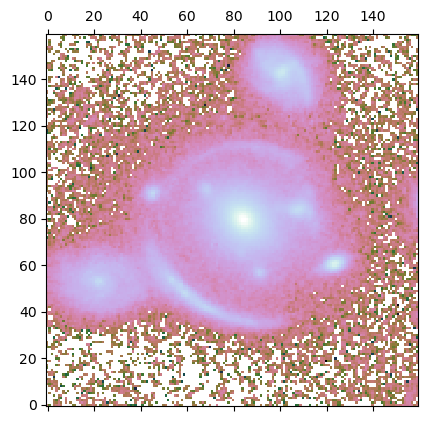

In [4]:
image_data = kwargs_data["image_data"]

plt.matshow(np.log10(image_data), origin="lower", cmap="cubehelix")
plt.show()

#### Make mask and plot it

/tmp/ipykernel_1112195/2285943441.py:56: RuntimeWarning: invalid value encountered in log10
  ax1.matshow(np.log10(image_data), origin='lower', cmap='cubehelix')
/tmp/ipykernel_1112195/2285943441.py:67: RuntimeWarning: divide by zero encountered in log10
  ax3.matshow(np.log10(masked_image_data), origin='lower', cmap='cubehelix')
/tmp/ipykernel_1112195/2285943441.py:67: RuntimeWarning: invalid value encountered in log10
  ax3.matshow(np.log10(masked_image_data), origin='lower', cmap='cubehelix')


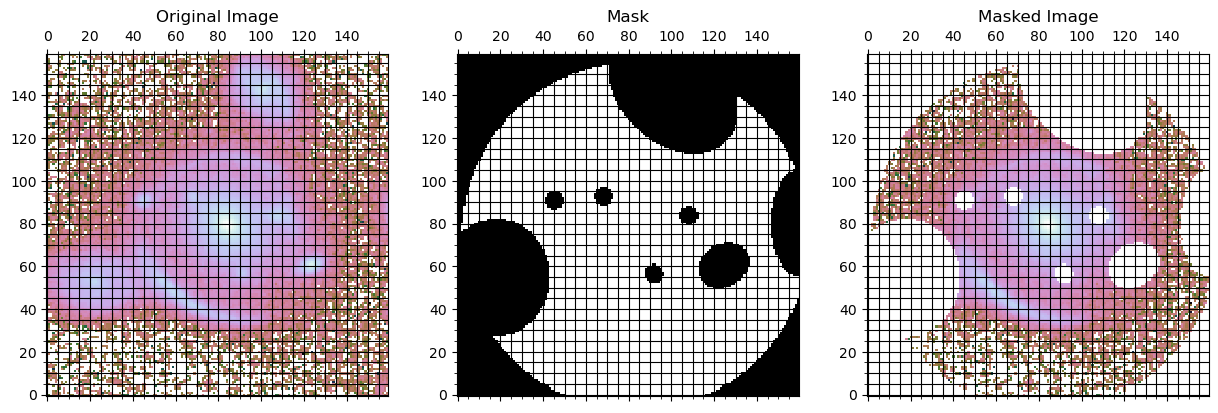

In [5]:
ra_at_xy_0 = kwargs_data["ra_at_xy_0"]
dec_at_xy_0 = kwargs_data["dec_at_xy_0"]
transform_pix2angle = kwargs_data["transform_pix2angle"]

coords = Coordinates(transform_pix2angle, ra_at_xy_0, dec_at_xy_0)
num_pix = len(kwargs_data["image_data"])

x_coords, y_coords = coords.coordinate_grid(num_pix, num_pix)

r = 6.5  # arcseconds
lens_center_ra = 0
lens_center_dec = 0

mask_outer = mask_util.mask_center_2d(
    lens_center_ra - 0.2,
    lens_center_dec - 0.5,
    r,
    util.image2array(x_coords),
    util.image2array(y_coords),
)

mask_params = [
    [-3.5, -1.6, 1, 0.8, -np.pi / 180 * 30],  # x, y, q, phi, theta
    [2.84, 0.85, 0.35, 0.35, 0],
    [1.0, 1.0, 0.35, 0.35, 0],
    [-0.9, -1.9, 0.35, 0.35, 0],
    [-2.2, 0.28, 0.35, 0.35, 0],
    [5, -2.04, 2, 2.2, np.pi],
    [-1.6, 5, 2.8, 2, np.pi / 4],
    [-6.28, 0, 2, 1, np.pi / 2],
]

mask = 1 - mask_outer

for mask_param in mask_params:
    mask *= 1 - mask_util.mask_ellipse(
        util.image2array(x_coords),
        util.image2array(y_coords),
        mask_param[0],
        mask_param[1],
        mask_param[2],
        mask_param[3],
        mask_param[4],
    )

mask[mask >= 1] = 1
mask[mask < 0] = 0

mask = mask.reshape(num_pix, num_pix)

# mask image data
masked_image_data = np.multiply(image_data, mask)

# plot image and masked image
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
ax1.matshow(np.log10(image_data), origin="lower", cmap="cubehelix")
ax1.grid(which="both", color="black")
ax1.minorticks_on()
ax1.grid(which="minor", color="black")
ax1.title.set_text("Original Image")
ax2.matshow(mask, origin="lower", cmap="cubehelix")
ax2.grid(which="both", color="black")
ax2.minorticks_on()
ax2.grid(which="minor", color="black")
ax2.title.set_text("Mask")
ax2.title.set_text("Mask")
ax3.matshow(np.log10(masked_image_data), origin="lower", cmap="cubehelix")
ax3.grid(which="both", color="black")
ax3.minorticks_on()
ax3.grid(which="minor", color="black")
ax3.title.set_text("Masked Image")
plt.show()